## PS 5-2
---

In [660]:
#Import required dependencies
import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [661]:
def load_image(image_path: str) -> str | np.ndarray:
    """Loads image from directory

    Args:
        image_path (str): path to image in current directory

    Returns:
        file_name: string of file name parsed from file path
        image: image from file path
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    file_name = Path(image_path).name
    
    return file_name, image

### Filters:

In [662]:
def closing(img: np.ndarray) -> np.ndarray:
    """Apply closing operation to image

    Args:
        img (np.ndarray): grayscale image

    Returns:
        np.ndarray: closed image
    """
    
    temp_img = img.copy()
    
    #Implementation of closing
    k_e = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    temp_img = cv2.dilate(temp_img,k_e)
    temp_img = cv2.erode(temp_img,k_e)
    
    return temp_img    

In [663]:
def adaptive_thresh(img: np.ndarray) -> np.ndarray:
    """Gaussian adaptive threshold

    Args:
        img (np.ndarray): grayscale image

    Returns:
        np.ndarray: binary image
    """
    temp_img = img.copy()
    
    temp_img = cv2.medianBlur(temp_img,5)
    temp_img = cv2.adaptiveThreshold(temp_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return temp_img

### Contour Tools:

In [664]:
def find_cont(img: np.ndarray) -> list:
    """Find contours in image

    Args:
        img (np.ndarray): binary image

    Returns:
        list: detected contours
    """
    
    temp_img = img.copy()
    
    #External contours chosen to ignore child contours
    cont, hier= cv2.findContours(temp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    return cont

In [665]:
def sort_cont(cont: list) -> list:
    """Simple sorting of contours from largest to smallest

    Args:
        cont (list): unsorted contours

    Returns:
        list: largest to smallest contours
    """
    
    cont_sorted = sorted(cont, key=cv2.contourArea, reverse=True)
    
    return cont_sorted

In [666]:
def extract_cont(cont: np.ndarray, img: np.ndarray) -> np.ndarray:
    """Crop specified contour from larger image

    Args:
        cont (np.ndarray): individual contour of interest
        img (np.ndarray): greater image contour is located in

    Returns:
        np.ndarray: cropped image containing just the contour
    """
    
    temp_img = img.copy()
    
    #using rotated min area rect to create bonds for cropping
    (center, (w,h), theta) = cv2.minAreaRect(cont)
    w = int(w+10) #10 chosen as buffer
    h = int(h+10)
    
    #detecting if rotation would lead to portrait or landscape
    #if portrait (h>w) corrects
    if h > w:
        temp = w
        w = h
        h = temp
        theta = theta + 90
    
    #Transformation to correct rotation of image in reference to min rect
    R_M = cv2.getRotationMatrix2D(center, theta, 1.0)
    rot_img = cv2.warpAffine(temp_img, R_M, (temp_img.shape[1], temp_img.shape[0]))
    
    #find corner of rectangle
    cont_x = int(center[0] - w / 2)
    cont_y = int(center[1] - h / 2)
    
    crop = rot_img[cont_y:cont_y+h, cont_x:cont_x+w]
    
    return crop
    

In [667]:
def remove_background(img: np.ndarray) -> np.ndarray:
    """Clean up image background and remove artifacts

    Args:
        img (np.ndarray): cropped image of cell

    Returns:
        np.ndarray: cropped image of cell on clean white background
    """
    
    temp_img = img.copy()
    
    #find dim of image
    h = temp_img.shape[0]
    w = temp_img.shape[1]
    
    #init mask for blob as black photo
    mask = np.zeros((h,w), dtype=np.uint8)
    
    #init mask for background as white photo
    background = np.bitwise_not(np.zeros((h,w),dtype=np.uint8))
    
    #find largest blob in image, ideally this is the cell
    cont, hier = cv2.findContours(temp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blob = max(cont, key=cv2.contourArea)
    
    #draw blob in white on mask to make mask 
    cv2.drawContours(mask, [blob], 0, (255,255,255), cv2.FILLED)
    
    #create inverse of blob mask for the background
    inv_mask = np.bitwise_not(mask)
    
    #apply masks to blob and background
    masked_img = cv2.bitwise_and(temp_img, temp_img, mask=mask)
    masked_background = cv2.bitwise_and(background,background, mask=inv_mask)
    
    #join blob and background
    final = cv2.add(masked_img,masked_background)
    
    return final
    

In [668]:
def make_img_array(cont: list, img: np.ndarray) -> list:
    """create array of cropped images of blobs

    Args:
        cont (list): ordered contours of image
        img (np.ndarray): greater image containing contours

    Returns:
        list: array of cropped images of inputted contours
    """
    
    temp_img = img.copy()
    
    #init list of images
    output = []
    
    #iterate over contour list
    for idx in range(len(cont)):
        
        #size threshold to filter out likely non cells
        if cv2.contourArea(cont[idx]) > 450:

                #get cropped photo of contour
                crop = extract_cont(cont[idx],temp_img)
                
                #filter when crop fails and returns blank image 
                if crop.size > 0:
                    
                    #clean up image
                    final = remove_background(crop)
                    
                    output.append(final)
    
    return output
    

### Main:

In [669]:
#load image
file_name, img = load_image("blood-cells1.jpg")
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

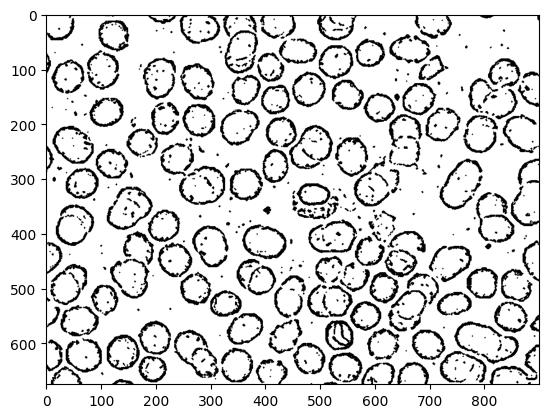

In [670]:
#deliverable 1
binary = adaptive_thresh(img)
binary = closing(binary)

cv2.imwrite(file_name.replace(".", "-binary."),binary)

plt.imshow(cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB))
plt.show()

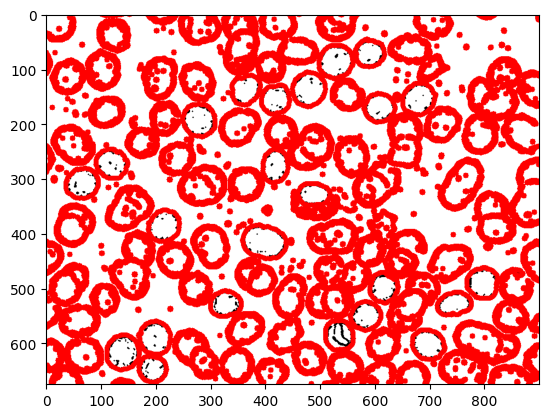

In [671]:
#deliverable 2
blob_img = cv2.cvtColor(binary.copy(), cv2.COLOR_GRAY2RGB)

cont = find_cont(cv2.bitwise_not(binary))
cv2.drawContours(blob_img, cont, -1, (255,0,0), 7)

cv2.imwrite(file_name.replace(".", "-blobs."),blob_img)

plt.imshow(blob_img)
plt.show()



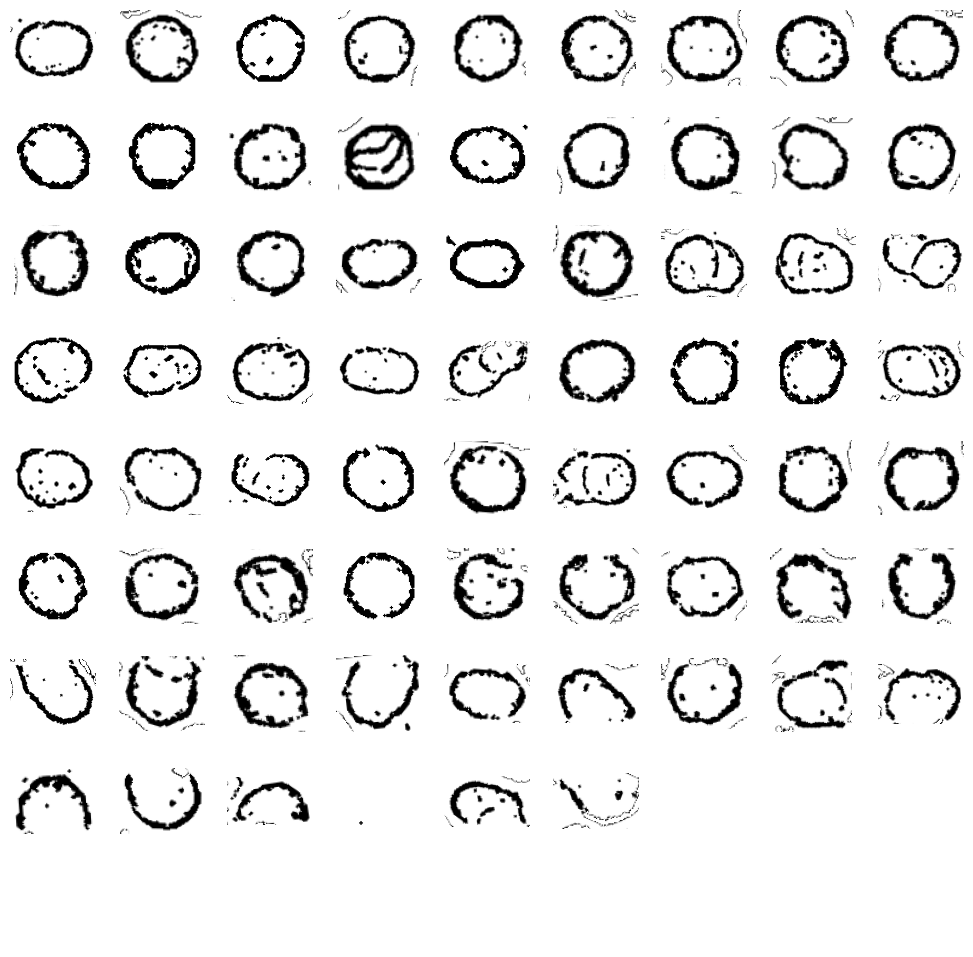

In [672]:
#deliverable 3

#creating sorted array of cropped cell images
cont = sort_cont(cont)
slide_deck = make_img_array(cont,binary)

#finding dimensions of chart
cell_dim = np.ceil(np.sqrt(len(slide_deck))) #round up to a squared int that can hold all images
cell_dim = int(cell_dim)

#init plot of subplots
fig, axs = plt.subplots(cell_dim, cell_dim,)
axs = axs.flatten() #improves speed when looping

#populate subplots
for idx in range(len(slide_deck)):
    
    ax = axs[idx]
    ax.imshow(cv2.cvtColor(slide_deck[idx], cv2.COLOR_GRAY2RGB))
    ax.axis('off') #needed for readability of final plot

#iterate over empty subplots and turn off axis
for i in range(len(slide_deck), len(axs)):
    axs[i].axis('off')    

fig.tight_layout() #auto spacing
fig.set_size_inches(10, 10) #dimensions of super plot

plt.savefig(file_name.replace(".", "-catalog."))

plt.show()